In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import tensorflow_datasets as tfds

In [ ]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete3X1JK7/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete3X1JK7/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
train_ds, valid_ds = ds["train"], ds["validation"]

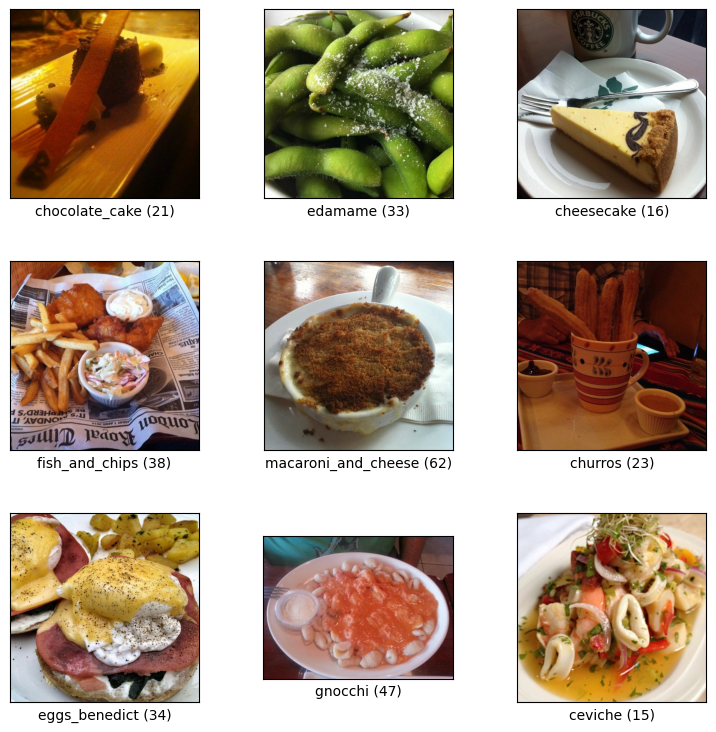

In [ ]:
fig = tfds.show_examples(train_ds, ds_info)

In [ ]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

ValueError: Image dimension should be 3. tfds.show_examples does not support batched examples or video.

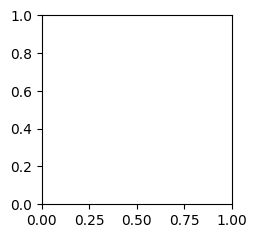

In [ ]:
fig = tfds.show_examples(train_ds, ds_info)

In [ ]:
train_hd_size, valid_hd_size = 750, 250

In [ ]:
train_hotdogs = train_ds.filter(lambda _, label: label == 1).repeat(3)
train_nothotdogs = train_ds.filter(lambda _, label: label == 0)

In [ ]:
valid_hotdogs = valid_ds.filter(lambda _, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda _, label: label == 0)

In [ ]:
valid_hotdogs

<_RepeatDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
batch_size = 16

train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs],
                                                weights=[0.5, 0.5],
                                                stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)


valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs],
                                                weights=[0.5, 0.5],
                                                stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# for image, label in train_ds.take(3):
#   print(image[0][0][0])
#   print(label)

for image_batch, label_batch in train_ds.take(1):
  print(image_batch)
  print(label_batch)

tf.Tensor(
[[[[ 67  30  13]
   [ 74  39  12]
   [149 118  84]
   ...
   [238 194 163]
   [221 176 149]
   [150 106  83]]

  [[ 65  32   8]
   [ 69  34   3]
   [ 79  44   9]
   ...
   [112  68  35]
   [148 108  77]
   [175 136 104]]

  [[134 100  58]
   [117  79  34]
   [ 83  45   3]
   ...
   [214 189 167]
   [229 201 173]
   [191 157 121]]

  ...

  [[198  67  14]
   [206  75  19]
   [202  72  16]
   ...
   [225 174 116]
   [224 172 116]
   [227 172 118]]

  [[201  72  14]
   [204  76  16]
   [198  69  11]
   ...
   [226 172 115]
   [224 174 115]
   [224 172 114]]

  [[202  74  12]
   [203  75  12]
   [201  73  13]
   ...
   [223 169 114]
   [223 172 115]
   [224 173 116]]]


 [[[ 21  25  30]
   [ 23  25  30]
   [ 23  24  28]
   ...
   [ 37  35  48]
   [ 45  40  53]
   [ 56  41  53]]

  [[ 26  27  31]
   [ 23  23  28]
   [ 26  25  31]
   ...
   [ 37  36  47]
   [ 42  40  50]
   [ 52  43  51]]

  [[ 37  30  29]
   [ 34  27  27]
   [ 35  29  32]
   ...
   [ 42  39  50]
   [ 40  36  45]


# Neural Network implementation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

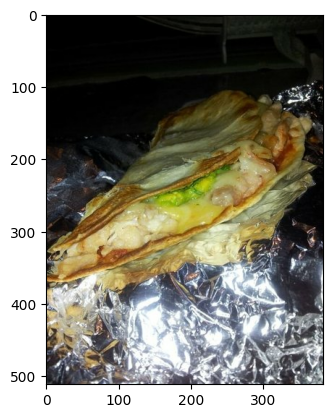

In [ ]:
for i,_ in ds['train'].take(1):
  image = i

plt.imshow(image)

In [ ]:
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

image /=255.0

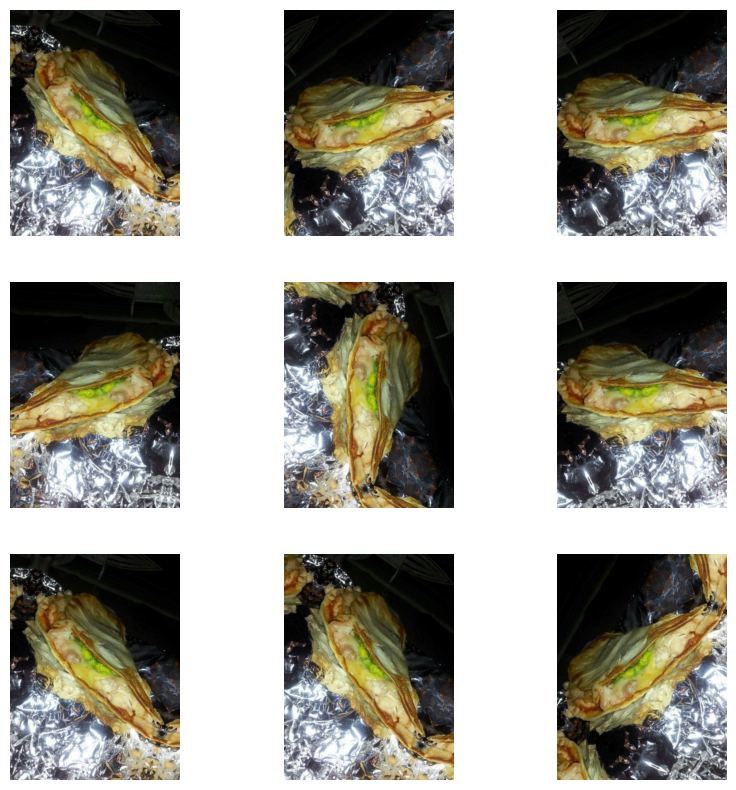

In [ ]:
plt.figure(figsize=(10,10))

for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3,3,i+1)
  plt.imshow(augmented_image[0])
  plt.axis('off')

In [ ]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(data_augmentation)

model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [ ]:
lr = 0.0001                                             # Learning Rate
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/10
287/287 [==============================] - 461s 2s/step - loss: 1.2989 - accuracy: 0.5125 - val_loss: 1.0620 - val_accuracy: 0.5082
Epoch 2/10
287/287 [==============================] - 10s 34ms/step - loss: 0.9506 - accuracy: 0.5330 - val_loss: 0.8715 - val_accuracy: 0.5075
Epoch 3/10
287/287 [==============================] - 10s 34ms/step - loss: 0.8244 - accuracy: 0.5435 - val_loss: 0.7847 - val_accuracy: 0.5154
Epoch 4/10
287/287 [==============================] - 10s 34ms/step - loss: 0.7657 - accuracy: 0.5598 - val_loss: 0.7385 - val_accuracy: 0.5384
Epoch 5/10
287/287 [==============================] - 10s 35ms/step - loss: 0.7334 - accuracy: 0.5727 - val_loss: 0.7079 - val_accuracy: 0.5495
Epoch 6/10
287/287 [==============================] - 10s 37ms/step - loss: 0.7053 - accuracy: 0.5847 - val_loss: 0.6770 - val_accuracy: 0.5797
Epoch 7/10
287/287 [==============================] - 10s 33ms/step - loss: 0.6873 - accuracy: 0.5995 - val_loss: 0.6503 - val_accuracy: 

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

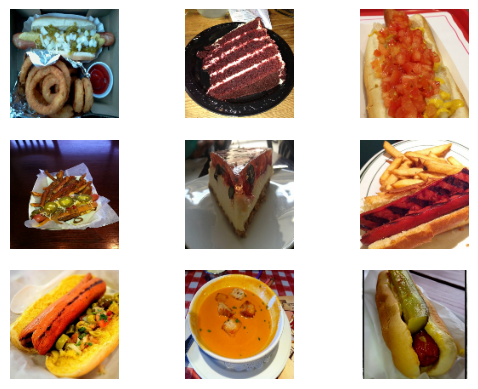

In [ ]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [ ]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 0, 1, 1, 0, 1, 1, 0, 1], dtype=int32)>